## Tutorial 07 - Non linear Elliptic problem
**_Keywords: DEIM, POD-Galerkin_**

### 1. Introduction

In this tutorial, we consider a non linear elliptic problem in a two-dimensional spatial domain $\Omega=(0,1)^2$. We impose a homogeneous Dirichlet condition on the boundary $\partial\Omega$. The source term is characterized by the following expression
$$
g(\boldsymbol{x}; \boldsymbol{\mu}) = 100\sin(2\pi x_0)cos(2\pi x_1) \quad \forall \boldsymbol{x} = (x_0, x_1) \in \Omega.
$$

This problem is characterized by two parameters. The first parameter $\mu_0$ controls the strength of the sink term and the second parameter $\mu_1$ the strength of the nonlinearity. The range of the two parameters is the following:
$$
\mu_0,\mu_1\in[0.01,10.0]
$$
The parameter vector $\boldsymbol{\mu}$ is thus given by
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.01,10]^2.
$$


In order to obtain a faster approximation of the problem, we pursue a model reduction by means of a POD-Galerkin reduced order method. In order to preserve the affinity assumption the discrete empirical interpolation method will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$.



### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the solution in the domain $\Omega$.

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that

$$ -\nabla^2u(\boldsymbol{\mu})+\frac{\mu_0}{\mu_1}(\exp\{\mu_1u(\boldsymbol{\mu})\}-1)=g(\boldsymbol{x}; \boldsymbol{\mu})$$
<br>
    
The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)+c\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H_1(\Omega) : v|_{\partial\Omega}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized bilinear form $c(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$c(u, v;\boldsymbol{\mu})=\mu_0\int_{\Omega} \frac{1}{\mu_1}\big(\exp\{\mu_1u\} - 1\big)v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \int_{\Omega}g(\boldsymbol{x}; \boldsymbol{\mu})v \ d\boldsymbol{x}.$$

The output of interest $s(\boldsymbol{\mu})$ is given by
$$s(\boldsymbol{\mu}) = \int_{\Omega} v \ d\boldsymbol{x}$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

### 3. Affine Decomposition 

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{1}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)},$$
$$c(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{c}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\frac{1}{\mu_1}\big(\exp\{\mu_1u\} - 1\big)v \ d\boldsymbol{x}}_{c_0(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{100}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Omega}\sin(2\pi x_0)cos(2\pi x_1)v \ d\boldsymbol{x}}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class NonlinearElliptic(NonlinearEllipticProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$, $\Theta^{c}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):
```
and the bilinear forms $a_*(u, v)$, $c_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
@DEIM("online", basis_generation="Greedy")
@ExactParametrizedFunctions("offline")
class NonlinearElliptic(NonlinearEllipticProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        NonlinearEllipticProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.du = TrialFunction(V)
        self.u = self._solution
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Store the forcing term expression
        self.f = Expression("sin(2*pi*x[0])*sin(2*pi*x[1])", element=self.V.ufl_element())
        # Customize nonlinear solver parameters
        self._nonlinear_solver_parameters.update({
            "linear_solver": "mumps",
            "maximum_iterations": 20,
            "report": True
        })

    # Return custom problem name
    def name(self):
        return "NonlinearEllipticDEIM"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_derivatives
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1.
            return (theta_a0,)
        elif term == "c":
            theta_c0 = mu[0]
            return (theta_c0,)
        elif term == "f":
            theta_f0 = 100.
            return (theta_f0,)
        elif term == "s":
            theta_s0 = 1.0
            return (theta_s0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_derivatives
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            du = self.du
            a0 = inner(grad(du), grad(v)) * dx
            return (a0,)
        elif term == "c":
            u = self.u
            mu = self.mu
            c0 = (exp(mu[1] * u) - 1) / mu[1] * v * dx
            return (c0,)
        elif term == "f":
            f = self.f
            f0 = f * v * dx
            return (f0,)
        elif term == "s":
            s0 = v * dx
            return (s0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1)]
            return (bc0,)
        elif term == "inner_product":
            du = self.du
            x0 = inner(grad(du), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")


# Customize the resulting reduced problem
@CustomizeReducedProblemFor(NonlinearEllipticProblem)
def CustomizeReducedNonlinearElliptic(ReducedNonlinearElliptic_Base):
    class ReducedNonlinearElliptic(ReducedNonlinearElliptic_Base):
        def __init__(self, truth_problem, **kwargs):
            ReducedNonlinearElliptic_Base.__init__(self, truth_problem, **kwargs)
            self._nonlinear_solver_parameters.update({
                "report": True,
                "line_search": "wolfe"
            })

    return ReducedNonlinearElliptic

## 4. Main program

### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/square.xml")
subdomains = MeshFunction("size_t", mesh, "data/square_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/square_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the NonlinearElliptic class

In [5]:
problem = NonlinearElliptic(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.01, 10.0), (0.01, 10.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20, DEIM=21)
reduction_method.set_tolerance(1e-8, DEIM=1e-5)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(50, DEIM=60)
reduced_problem = reduction_method.offline()

#### 4.5.2 Train Greedy PDNN-PINN

In [8]:
input_normalization_pdnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.MinMaxNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

pdnn_net.VERBOSE = False

Initial training...
0 0.2928635554733591 	Loss(validation) = 0.38467457739569155
100 0.09835675059592112 	Loss(validation) = 0.20352573024185444
200 0.04832984876737339 	Loss(validation) = 0.14798359632499494
300 0.023866918601334282 	Loss(validation) = 0.11020828073897466
400 0.01261245791775847 	Loss(validation) = 0.08670694084149531
500 0.007789645279777565 	Loss(validation) = 0.07855931041667008
600 0.0050947637535402 	Loss(validation) = 0.0754111112486286
700 0.003515405259545498 	Loss(validation) = 0.0742071804037012
800 0.0026214746360369136 	Loss(validation) = 0.07267075256211997
900 0.002068203996658131 	Loss(validation) = 0.07018024453054225
1000 0.0016727144152388538 	Loss(validation) = 0.06717738444471257
1100 0.0013678551802288606 	Loss(validation) = 0.06404687765216333
1200 0.0011286108458177088 	Loss(validation) = 0.06096399713225344
1300 0.0009411291994561198 	Loss(validation) = 0.05804224351552908
1400 0.0007920062478652519 	Loss(validation) = 0.05531522555009168
1500 

2:  |F(x)| = 0.153231; step 1
3:  |F(x)| = 0.00356203; step 1
4:  |F(x)| = 2.69075e-06; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 3.1879; step 0.406085
1:  |F(x)| = 0.914333; step 1
2:  |F(x)| = 0.110669; step 1
3:  |F(x)| = 0.00221427; step 1
4:  |F(x)| = 1.57857e-06; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 3.64631; step 0.314802
1:  |F(x)| = 2.75278; step 0.234613
2:  |F(x)| = 0.804717; step 1
3:  |F(x)| = 0.0978687; step 1
4:  |F(x)| = 0.00192038; step 1
5:  |F(x)| = 8.10398e-06; step 1
6:  |F(x)| = 7.24161e-08; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 3.64631; step 0.314802
1:  |F(x)| = 2.75278; step 0.234613
2:  |F(x)| = 0.804717; step 1
3:  |F(x)| = 0.0978688; step 1
4:  |F(x)| = 0.00192038; step 1
5:  |F(x)| = 8.10398e-06; step 1
6:  |F(x)| = 7.24161e-08; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 0.0296517; step 1
1:  |F(x)| = 4.16408e-06; step 1
scipy solver converged in 3 iterations.
0:  |F(x)| = 0.0296

1:  |F(x)| = 0.00260253; step 1
2:  |F(x)| = 2.50723e-06; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 0.317293; step 1
1:  |F(x)| = 0.00260253; step 1
2:  |F(x)| = 2.50723e-06; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 2.70693; step 0.483551
1:  |F(x)| = 0.384392; step 1
2:  |F(x)| = 0.0202192; step 1
3:  |F(x)| = 6.58803e-05; step 1
4:  |F(x)| = 1.61577e-07; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 3.6227; step 0.331303
1:  |F(x)| = 1.86406; step 0.456063
2:  |F(x)| = 0.156313; step 1
3:  |F(x)| = 0.00420168; step 1
4:  |F(x)| = 3.51331e-06; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 0.110625; step 1
1:  |F(x)| = 0.000134339; step 1
2:  |F(x)| = 4.51352e-07; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 0.110625; step 1
1:  |F(x)| = 0.000134339; step 1
2:  |F(x)| = 4.51352e-07; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 0.161824; step 1
1:  |F(x)| = 0.000562306; step 1
2:  |F(x)| = 1.9

scipy solver converged in 5 iterations.
0:  |F(x)| = 3.45542; step 0.362556
1:  |F(x)| = 1.74924; step 0.463165
2:  |F(x)| = 0.145687; step 1
3:  |F(x)| = 0.00397573; step 1
4:  |F(x)| = 4.25082e-06; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 3.45542; step 0.362556
1:  |F(x)| = 1.74924; step 0.463165
2:  |F(x)| = 0.145687; step 1
3:  |F(x)| = 0.00397574; step 1
4:  |F(x)| = 4.25083e-06; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 3.65952; step 0.3268
1:  |F(x)| = 2.56426; step 0.286705
2:  |F(x)| = 0.633824; step 1
3:  |F(x)| = 0.0644928; step 1
4:  |F(x)| = 0.000812798; step 1
5:  |F(x)| = 1.54188e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.65952; step 0.3268
1:  |F(x)| = 2.56426; step 0.286705
2:  |F(x)| = 0.633824; step 1
3:  |F(x)| = 0.0644927; step 1
4:  |F(x)| = 0.000812796; step 1
5:  |F(x)| = 1.54187e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 4.21894; step 0.235187
1:  |F(x)| = 2.13258; step 0.472363


0:  |F(x)| = 3.71545; step 0.316431
1:  |F(x)| = 2.26446; step 0.35042
2:  |F(x)| = 0.44222; step 1
3:  |F(x)| = 0.0385942; step 1
4:  |F(x)| = 0.00034329; step 1
5:  |F(x)| = 1.74277e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 2.74284; step 0.479069
1:  |F(x)| = 0.447512; step 1
2:  |F(x)| = 0.0297699; step 1
3:  |F(x)| = 0.000146081; step 1
4:  |F(x)| = 1.21951e-07; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 0.423048; step 1
1:  |F(x)| = 0.0146493; step 1
2:  |F(x)| = 1.95952e-05; step 1
3:  |F(x)| = 1.04909e-08; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 0.513036; step 1
1:  |F(x)| = 0.0454647; step 1
2:  |F(x)| = 0.000393675; step 1
3:  |F(x)| = 4.61353e-08; step 1
scipy solver converged in 5 iterations.
Beginning data augmentation cycles...


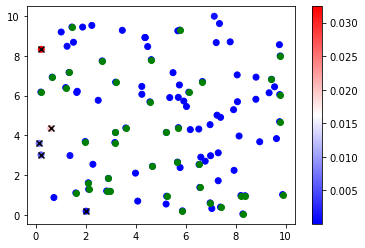

10000 0.000800895041747471 	Loss(validation) = 0.0017691512379647862
10100 0.0004831468829457161 	Loss(validation) = 0.0012785236713500788
10200 0.00035875130172144555 	Loss(validation) = 0.0011135400808912625
10300 0.0002844023658640063 	Loss(validation) = 0.0009933915778731484
10400 0.00023511170888533534 	Loss(validation) = 0.0008969658992261737
10500 0.00020054348149752365 	Loss(validation) = 0.0008185675477144414
10600 0.00017506413070660418 	Loss(validation) = 0.0007530478469552564
10700 0.00015528726208280662 	Loss(validation) = 0.000696345655568878
10800 0.0001391883113470812 	Loss(validation) = 0.0006462366796892503
10900 0.000125968362044338 	Loss(validation) = 0.0006037540677558084
11000 0.0001145141806093765 	Loss(validation) = 0.0005648531151564568
11100 0.00012501040228179945 	Loss(validation) = 0.0005548916583244185
11200 9.553223183325345e-05 	Loss(validation) = 0.0005025701307748644
11300 8.762779171732646e-05 	Loss(validation) = 0.0004780003900839324
11400 8.049495943

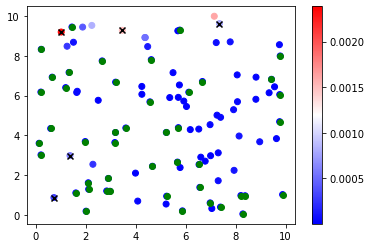

20000 7.76234254895118e-05 	Loss(validation) = 0.0002002530780570055
20100 4.7201736674310194e-05 	Loss(validation) = 0.0001763805001859866
20200 3.2096953851450955e-05 	Loss(validation) = 0.000161160039251094
20300 3.7677853237144965e-05 	Loss(validation) = 0.00015651597467749909
20400 2.0388505851337752e-05 	Loss(validation) = 0.0001612081304181526
20500 1.7606092706720732e-05 	Loss(validation) = 0.00016212711238002366
20600 2.205433393472842e-05 	Loss(validation) = 0.0001746171855796075
20700 2.178924536293763e-05 	Loss(validation) = 0.00016787959514667316
20800 1.4736510966751538e-05 	Loss(validation) = 0.000166265692657158
20900 1.2109795997015545e-05 	Loss(validation) = 0.00016373055655214265
21000 1.1445539820075144e-05 	Loss(validation) = 0.0001616004284175686
21100 1.0679541594922903e-05 	Loss(validation) = 0.00016303489981859355
21200 1.0745014446528378e-05 	Loss(validation) = 0.00016430595024976598
21300 1.1202362898382076e-05 	Loss(validation) = 0.0001620823715686582
21400 

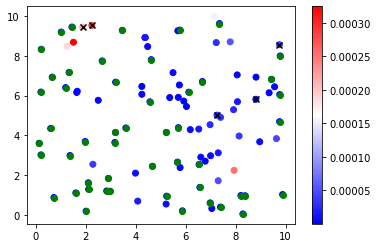

30000 1.5719528840010096e-05 	Loss(validation) = 0.00015231092142793516
30100 1.3553142190418797e-05 	Loss(validation) = 0.0001352101587851502
30200 1.2346088666376931e-05 	Loss(validation) = 0.00012655575786290767
30300 1.1556937676806088e-05 	Loss(validation) = 0.00012106859645703737
30400 1.0775665170921542e-05 	Loss(validation) = 0.00011622450562198984
30500 1.0192254367984892e-05 	Loss(validation) = 0.00011215818271919972
30600 9.977648397156087e-06 	Loss(validation) = 0.00010883972564027934
30700 9.444657521337514e-06 	Loss(validation) = 0.00010485529145425727
30800 8.818928139053028e-06 	Loss(validation) = 0.00010446560723080623
30900 8.469781061084778e-06 	Loss(validation) = 0.00010313590395015807
31000 8.304493716786393e-06 	Loss(validation) = 0.00010227823403466393
31100 7.94022853367226e-06 	Loss(validation) = 9.973276918687397e-05
31200 8.489303141997815e-06 	Loss(validation) = 0.00010797110104205606
31300 8.431928087041805e-06 	Loss(validation) = 9.092217523060533e-05
3140

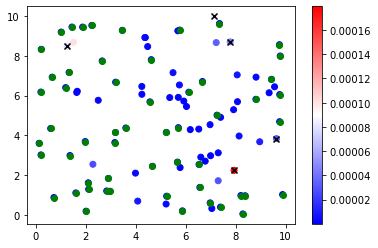

40000 1.3424745444583083e-05 	Loss(validation) = 4.212857366472037e-05
40100 1.0705815962522753e-05 	Loss(validation) = 3.773902181129566e-05
40200 9.345416109933697e-06 	Loss(validation) = 3.624415774971392e-05
40300 8.684022169732975e-06 	Loss(validation) = 3.4251222373332396e-05
40400 1.8783400596671676e-05 	Loss(validation) = 4.520489774628006e-05
40500 1.1795775517846645e-05 	Loss(validation) = 4.198120664282615e-05
40600 7.025943989519698e-06 	Loss(validation) = 3.277121638117589e-05
40700 6.762059981270835e-06 	Loss(validation) = 3.195413224949732e-05
40800 7.19852452140262e-06 	Loss(validation) = 3.3737384694222155e-05
40900 6.8508187633398196e-06 	Loss(validation) = 3.1889794153733164e-05
41000 2.065178657057689e-05 	Loss(validation) = 5.278789145890114e-05
41100 5.940004624709222e-06 	Loss(validation) = 3.1722346159671205e-05
41200 6.54495631554734e-06 	Loss(validation) = 3.057300520372567e-05
41300 5.7579595119576105e-06 	Loss(validation) = 3.181964994840233e-05
41400 5.5461

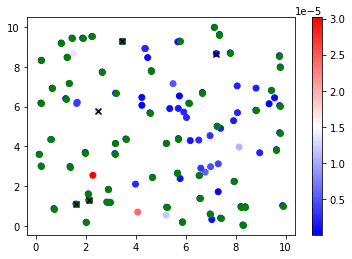

50000 7.426450495590007e-06 	Loss(validation) = 2.966709025472853e-05
50100 6.7381712352743464e-06 	Loss(validation) = 2.8065358244519315e-05
50200 6.4021522155311924e-06 	Loss(validation) = 2.6930950067647382e-05
50300 6.1586897026317105e-06 	Loss(validation) = 2.6088501786357513e-05
50400 6.013841295081951e-06 	Loss(validation) = 2.562645775039405e-05
50500 6.4305123277018e-06 	Loss(validation) = 2.641143713640868e-05
50600 5.7506972429195345e-06 	Loss(validation) = 2.4540089759553142e-05
50700 6.06502472311567e-06 	Loss(validation) = 2.4256693746681348e-05
50800 5.757166695323268e-06 	Loss(validation) = 2.4238293715674646e-05
50900 5.60973809146622e-06 	Loss(validation) = 2.3713996064596656e-05
51000 6.559166731144638e-06 	Loss(validation) = 2.600528075554454e-05
51100 5.289081311898994e-06 	Loss(validation) = 2.3565215969126204e-05
51200 5.227839105016278e-06 	Loss(validation) = 2.352586333395675e-05
51300 5.313823827094191e-06 	Loss(validation) = 2.3497608866931996e-05
51400 5.092

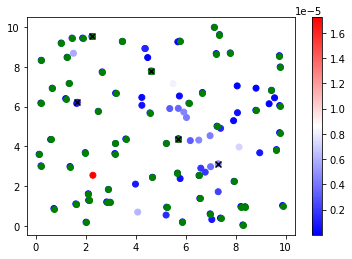

60000 4.439374199225057e-06 	Loss(validation) = 1.9439987855775582e-05
60100 4.253819568338228e-06 	Loss(validation) = 1.927009747333722e-05
60200 4.3946109365125245e-06 	Loss(validation) = 2.001649460691381e-05
60300 7.5628854933240975e-06 	Loss(validation) = 1.9726044222968017e-05
60400 4.594076437699398e-06 	Loss(validation) = 1.988641789481566e-05
60500 3.9735149108858044e-06 	Loss(validation) = 1.9121841129257064e-05
60600 4.427425168634802e-06 	Loss(validation) = 1.929042962137483e-05
60700 4.621437748114778e-06 	Loss(validation) = 2.006521461327671e-05
60800 7.99658607975849e-06 	Loss(validation) = 2.319186297874083e-05
60900 4.187297621718793e-06 	Loss(validation) = 1.9602094550196106e-05
61000 3.7940293813270163e-06 	Loss(validation) = 1.8962935403375372e-05
61100 4.020542170962901e-06 	Loss(validation) = 1.9809235287670047e-05
61200 3.7141495846942892e-06 	Loss(validation) = 1.896384216193682e-05
61300 3.783200257554769e-06 	Loss(validation) = 1.9288113661873627e-05
61400 3.6

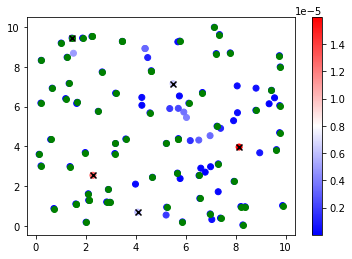

70000 1.3446861414483826e-05 	Loss(validation) = 2.1307785244769674e-05
70100 9.551855247368367e-06 	Loss(validation) = 1.853117921011857e-05
70200 9.754132658355111e-06 	Loss(validation) = 1.8374618643187893e-05
70300 9.122934936050608e-06 	Loss(validation) = 1.768425749322774e-05
70400 8.9737302406639e-06 	Loss(validation) = 1.752094505972813e-05
70500 9.130113735319684e-06 	Loss(validation) = 1.69120500410477e-05
70600 8.839961421641858e-06 	Loss(validation) = 1.7921121838112214e-05
70700 8.579315705763715e-06 	Loss(validation) = 1.7367854523753798e-05
70800 1.7989213936071075e-05 	Loss(validation) = 2.316423598437157e-05
70900 8.504484563626729e-06 	Loss(validation) = 1.697954454831819e-05
71000 1.0687166655989096e-05 	Loss(validation) = 1.7704938109268214e-05
71100 8.247981092245987e-06 	Loss(validation) = 1.713772869704559e-05
71200 8.312273125807758e-06 	Loss(validation) = 1.6922759636811182e-05
71300 8.46959433310698e-06 	Loss(validation) = 1.6644182094452454e-05
71400 8.399709

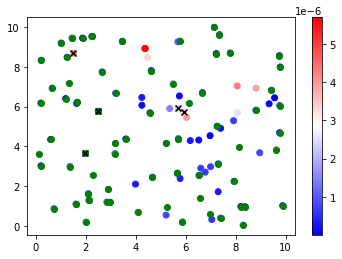

80000 8.696637569087375e-06 	Loss(validation) = 2.274770759475908e-05
80100 7.570298247959066e-06 	Loss(validation) = 2.2833496261696528e-05
80200 7.505350241393828e-06 	Loss(validation) = 2.2864335044056284e-05
80300 1.18663577941177e-05 	Loss(validation) = 3.08405898354646e-05
80400 7.520721879365936e-06 	Loss(validation) = 2.2743446753332993e-05
80500 7.387126115248952e-06 	Loss(validation) = 2.275090633987481e-05
80600 8.04235793047435e-06 	Loss(validation) = 2.433586791318241e-05
80700 7.488012504713268e-06 	Loss(validation) = 2.2175024576520608e-05
80800 8.847059780607778e-06 	Loss(validation) = 2.260900581714784e-05
80900 7.878797777391613e-06 	Loss(validation) = 2.33965869399054e-05
81000 9.024715699932258e-06 	Loss(validation) = 2.6195780073764487e-05
81100 7.941127350149602e-06 	Loss(validation) = 2.3083398704122962e-05
81200 1.3459897760331288e-05 	Loss(validation) = 3.061446655749678e-05
81300 7.638740547157598e-06 	Loss(validation) = 2.2980147983724308e-05
81400 7.21036229

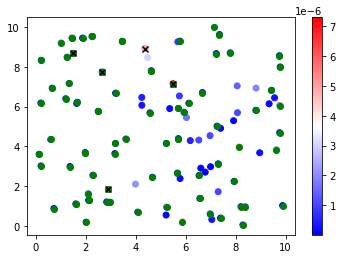

90000 7.095543697121276e-06 	Loss(validation) = 2.492842785860534e-05
90100 6.881551756086813e-06 	Loss(validation) = 2.5109834806256864e-05
90200 7.067758822485202e-06 	Loss(validation) = 2.461299480588455e-05
90300 7.798557394900249e-06 	Loss(validation) = 2.4259328223988894e-05
90400 7.0062462079845356e-06 	Loss(validation) = 2.370874025844683e-05
90500 6.803018909704177e-06 	Loss(validation) = 2.456899219942921e-05
90600 6.802172500535907e-06 	Loss(validation) = 2.4664447855191967e-05
90700 6.786661264181199e-06 	Loss(validation) = 2.4629977308575455e-05
90800 6.867458932940789e-06 	Loss(validation) = 2.440802041514749e-05
90900 6.766070416900532e-06 	Loss(validation) = 2.4620161194883025e-05
91000 8.646667888423915e-06 	Loss(validation) = 2.8714000036135947e-05
91100 6.751301214303998e-06 	Loss(validation) = 2.4758623612148726e-05
91200 6.756538615452674e-06 	Loss(validation) = 2.4276768272888195e-05
91300 6.763674644771859e-06 	Loss(validation) = 2.4771502654514664e-05
91400 7.15

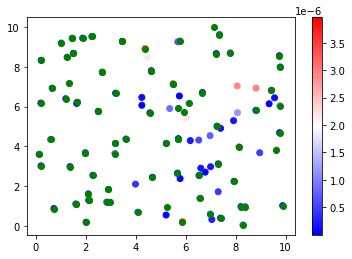

In [9]:
n = 100 # number of parameters for which we compute residuals each iteration
num_new_params = 5 # number of parameters with which we augment data each iteration

# train PDNN
print("Initial training...")
pdnn_trainer.train()

reduction_method.initialize_testing_set(n, DEIM=60)
new_parameters = pdnn_net.augment_parameters_with_time(
    torch.tensor(reduction_method.testing_set)
)

print("Assembling residuals...")
residuals, _, loss_functions = ErrorAnalysis.get_residuals(
    pdnn_net, data, new_parameters, 
    input_normalization_pdnn, output_normalization_pdnn,
    plot_residuals=True
)


print("Beginning data augmentation cycles...")
for i in range(9):
    probabilities = residuals
    probabilities /= np.sum(probabilities)
    sample_indices = np.random.choice(residuals.shape[0], size=residuals.shape[0],
                                      replace=False, p=probabilities)
    cumulative_probs = np.cumsum(probabilities[sample_indices])
    #last_index = np.searchsorted(cumulative_probs, 0.25) + 1
    #sample_indices = sample_indices[:last_index]
    sample_indices = sample_indices[:num_new_params]
    high_residual_params = new_parameters[sample_indices]
    plt.scatter(high_residual_params[:, 0].numpy().reshape(-1), 
                high_residual_params[:, 1].numpy().reshape(-1), marker='x', color='black')
    
    plt.show()
    
    # solve reduced PDE system for parameters found above and augment training data
    for j, mu in enumerate(high_residual_params):
        reduced_problem.set_mu(tuple(np.array(mu)))
        reduced_problem.solve()
        solution = torch.tensor(np.array(reduced_problem._solution.vector()[:])).view(-1, 1)
        pdnn_loss.concatenate_snapshots(solution)
        
    data.train_data = torch.cat([data.train_data, high_residual_params])
    
    # train PDNN
    pdnn_trainer.train()
    
    residuals, _, _ = ErrorAnalysis.get_residuals(
        pdnn_net, data, new_parameters, 
        input_normalization_pdnn, output_normalization_pdnn,
        loss_functions, plot_residuals=True
    )

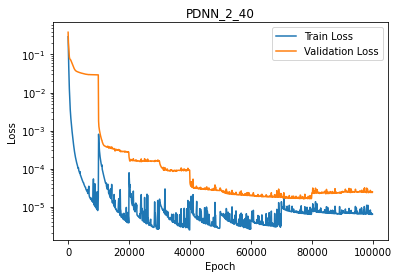

In [10]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.3 Train PRNN

In [11]:
input_normalization_prnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_prnn = Normalization.MinMaxNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=119)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=100000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [12]:
prnn_trainer.train()

0:  |F(x)| = 0.493193; step 1
1:  |F(x)| = 0.00928114; step 1
2:  |F(x)| = 6.00614e-06; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 0.0624951; step 1
1:  |F(x)| = 4.94307e-05; step 1
2:  |F(x)| = 4.12948e-09; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 2.90506; step 0.458997
1:  |F(x)| = 0.960909; step 1
2:  |F(x)| = 0.146894; step 1
3:  |F(x)| = 0.0048496; step 1
4:  |F(x)| = 2.06646e-06; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 0.838716; step 1
1:  |F(x)| = 0.0548497; step 1
2:  |F(x)| = 0.000302679; step 1
3:  |F(x)| = 1.97444e-07; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 4.67088; step 0.154074
1:  |F(x)| = 3.43337; step 0.260275
2:  |F(x)| = 1.31161; step 1
3:  |F(x)| = 0.218681; step 1
4:  |F(x)| = 0.00890335; step 1
5:  |F(x)| = 1.03077e-05; step 1
6:  |F(x)| = 7.37811e-08; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 3.71684; step 0.313409
1:  |F(x)| = 1.61637; step 0.496197
2:  |F(x)| = 0.06436

1:  |F(x)| = 3.67568e-05; step 1
2:  |F(x)| = 2.37727e-07; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 3.66681; step 0.312851
1:  |F(x)| = 2.57399; step 0.283678
2:  |F(x)| = 0.561886; step 1
3:  |F(x)| = 0.0507972; step 1
4:  |F(x)| = 0.00047861; step 1
5:  |F(x)| = 3.00587e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.76153; step 0.316455
1:  |F(x)| = 1.26301; step 1
2:  |F(x)| = 0.20168; step 1
3:  |F(x)| = 0.00732324; step 1
4:  |F(x)| = 6.98233e-06; step 1
5:  |F(x)| = 5.30624e-08; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 0.00701236; step 1
1:  |F(x)| = 2.11998e-06; step 1
scipy solver converged in 3 iterations.
0:  |F(x)| = 3.70456; step 0.316975
1:  |F(x)| = 2.25917; step 0.348797
2:  |F(x)| = 0.422511; step 1
3:  |F(x)| = 0.0354052; step 1
4:  |F(x)| = 0.000284412; step 1
5:  |F(x)| = 1.88222e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 1.40837; step 1
1:  |F(x)| = 0.161122; step 1
2:  |F(x)| = 0.003039

scipy solver converged in 7 iterations.
0:  |F(x)| = 3.70828; step 0.315512
1:  |F(x)| = 2.06859; step 0.39353
2:  |F(x)| = 0.250449; step 1
3:  |F(x)| = 0.0131119; step 1
4:  |F(x)| = 2.62244e-05; step 1
5:  |F(x)| = 6.36622e-07; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 0.199608; step 1
1:  |F(x)| = 0.000675791; step 1
2:  |F(x)| = 9.35132e-07; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 2.14721; step 0.44596
1:  |F(x)| = 0.149124; step 1
2:  |F(x)| = 0.00890256; step 1
3:  |F(x)| = 0.000263011; step 1
4:  |F(x)| = 8.10533e-06; step 1
5:  |F(x)| = 9.08872e-08; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.7112; step 0.310994
1:  |F(x)| = 2.44008; step 0.325461
2:  |F(x)| = 0.436224; step 1
3:  |F(x)| = 0.0306343; step 1
4:  |F(x)| = 0.000158032; step 1
5:  |F(x)| = 8.16448e-07; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 4.3849; step 0.205624
1:  |F(x)| = 3.18698; step 0.269438
2:  |F(x)| = 1.58425; step 0.477993
3:  |

1:  |F(x)| = 0.416964; step 1
2:  |F(x)| = 0.024145; step 1
3:  |F(x)| = 9.36738e-05; step 1
4:  |F(x)| = 1.19687e-07; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 0.34151; step 1
1:  |F(x)| = 0.0151553; step 1
2:  |F(x)| = 3.06329e-05; step 1
3:  |F(x)| = 3.31596e-09; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 3.694; step 0.311244
1:  |F(x)| = 2.50442; step 0.306203
2:  |F(x)| = 0.489414; step 1
3:  |F(x)| = 0.0386037; step 1
4:  |F(x)| = 0.000262255; step 1
5:  |F(x)| = 1.54387e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 0.671532; step 1
1:  |F(x)| = 0.0552651; step 1
2:  |F(x)| = 0.000438515; step 1
3:  |F(x)| = 1.12349e-07; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 1.1492; step 1
1:  |F(x)| = 0.10318; step 1
2:  |F(x)| = 0.00114728; step 1
3:  |F(x)| = 8.00523e-07; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 0.111615; step 1
1:  |F(x)| = 0.000135071; step 1
2:  |F(x)| = 5.08797e-07; step 1
scipy 

5:  |F(x)| = 9.51689e-08; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.17857; step 0.411015
1:  |F(x)| = 1.22269; step 1
2:  |F(x)| = 0.205084; step 1
3:  |F(x)| = 0.00860132; step 1
4:  |F(x)| = 8.89007e-06; step 1
5:  |F(x)| = 5.68339e-08; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.69849; step 0.318387
1:  |F(x)| = 2.59147; step 0.28645
2:  |F(x)| = 0.623849; step 1
3:  |F(x)| = 0.0610199; step 1
4:  |F(x)| = 0.000701727; step 1
5:  |F(x)| = 1.66292e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 0.822668; step 1
1:  |F(x)| = 0.0447474; step 1
2:  |F(x)| = 0.000174693; step 1
3:  |F(x)| = 2.01841e-07; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 0.0193546; step 1
1:  |F(x)| = 9.71138e-06; step 1
2:  |F(x)| = 9.34041e-08; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 0.0673044; step 1
1:  |F(x)| = 6.28615e-05; step 1
2:  |F(x)| = 5.24176e-09; step 1
scipy solver converged in 4 iterations.
0 0.59996857469

10700 2.9134963598269173e-05 	Loss(validation) = 0.01392354969391838
10800 2.994677056015316e-05 	Loss(validation) = 0.013866911882989686
10900 2.7965657850392996e-05 	Loss(validation) = 0.013818901923002325
11000 2.3019735969790554e-05 	Loss(validation) = 0.013774530565061316
11100 2.254118802248914e-05 	Loss(validation) = 0.01373139904239343
11200 2.2243363606568374e-05 	Loss(validation) = 0.013662581877448923
11300 2.1900259440699925e-05 	Loss(validation) = 0.013594710157529152
11400 2.1579565603855514e-05 	Loss(validation) = 0.013519397464656815
11500 2.1304564637418196e-05 	Loss(validation) = 0.01345530687046708
11600 2.0956270668298322e-05 	Loss(validation) = 0.013389269809799266
11700 2.0671134862138908e-05 	Loss(validation) = 0.013326271924527908
11800 2.059844413119237e-05 	Loss(validation) = 0.013245125186337449
11900 2.0702983663562936e-05 	Loss(validation) = 0.013186478068195263
12000 2.228151073931063e-05 	Loss(validation) = 0.013250043959897385
12100 2.8759816777969942e-0

22600 1.131740082148342e-05 	Loss(validation) = 0.010678167203091235
22700 6.575473749919269e-06 	Loss(validation) = 0.010705704359290066
22800 6.5431163016246654e-06 	Loss(validation) = 0.010707885082205843
22900 6.552613906166854e-06 	Loss(validation) = 0.010687496946503727
23000 8.233150904018792e-06 	Loss(validation) = 0.01066780194395255
23100 4.229728691641433e-05 	Loss(validation) = 0.010486204477713418
23200 9.511439216836779e-06 	Loss(validation) = 0.010687897887943505
23300 2.4761796878486197e-05 	Loss(validation) = 0.010480970805295128
23400 6.241715126773092e-06 	Loss(validation) = 0.010660808664301767
23500 8.663442066269561e-06 	Loss(validation) = 0.010706194611875974
23600 6.145174315251249e-06 	Loss(validation) = 0.010656594486616216
23700 6.182463458706803e-06 	Loss(validation) = 0.01063735633468627
23800 6.3597764332571635e-06 	Loss(validation) = 0.01061521073902747
23900 7.1407100402138784e-06 	Loss(validation) = 0.01067932759600133
24000 6.68107362807282e-06 	Loss(v

34500 1.1944369924573988e-05 	Loss(validation) = 0.010216316247171276
34600 3.1942295777280874e-06 	Loss(validation) = 0.010207580898525831
34700 3.1918240287868343e-06 	Loss(validation) = 0.010206216774152541
34800 4.8800765435666476e-05 	Loss(validation) = 0.01054200082140329
34900 3.149579948247161e-06 	Loss(validation) = 0.010198333057129213
35000 2.747617838047587e-05 	Loss(validation) = 0.010093428054938344
35100 3.206401032907656e-06 	Loss(validation) = 0.01021356282130655
35200 8.105569429314476e-06 	Loss(validation) = 0.010225305348520869
35300 3.089604136976613e-06 	Loss(validation) = 0.010188252399570512
35400 5.394982081799026e-06 	Loss(validation) = 0.010240490320819015
35500 3.9100711297611606e-06 	Loss(validation) = 0.010166538102865254
35600 3.470499988765603e-06 	Loss(validation) = 0.010250942075434824
35700 4.820715957232964e-06 	Loss(validation) = 0.010151454687795245
35800 9.141927674463974e-06 	Loss(validation) = 0.010145947188350362
35900 3.0022103023676116e-06 	L

46400 6.557875015801444e-06 	Loss(validation) = 0.009829149680835121
46500 9.169604651170853e-06 	Loss(validation) = 0.009748916217345976
46600 1.0590483757644002e-05 	Loss(validation) = 0.009882676258557066
46700 2.224805945323764e-06 	Loss(validation) = 0.00983109548405021
46800 1.993574866936055e-06 	Loss(validation) = 0.009850282496865677
46900 2.4602896062793665e-06 	Loss(validation) = 0.009851684859169102
47000 7.233427687047551e-06 	Loss(validation) = 0.009892804116790721
47100 2.2612715594922707e-06 	Loss(validation) = 0.009866020412674334
47200 1.9725526136308218e-06 	Loss(validation) = 0.009858427121802087
47300 2.02340009428851e-06 	Loss(validation) = 0.00983083839561518
47400 3.4538342637454213e-06 	Loss(validation) = 0.009817633356326938
47500 2.3818253250616645e-06 	Loss(validation) = 0.009803818578319143
47600 2.5907200535594727e-06 	Loss(validation) = 0.00985113969955286
47700 1.940038336398071e-06 	Loss(validation) = 0.009823802960320892
47800 2.0289378826547113e-06 	L

KeyboardInterrupt: 

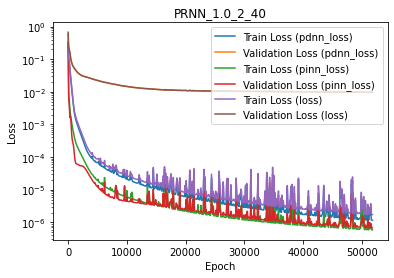

In [13]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

#### 4.5.4 Train PINN

In [14]:
input_normalization_pinn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pinn = Normalization.MinMaxNormalization()

pinn_net  = NN.RONN(f"PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2,
                                    num_without_snapshots=119)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=100000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [15]:
pinn_trainer.train()

0:  |F(x)| = 2.25938; step 0.446504
1:  |F(x)| = 0.125215; step 1
2:  |F(x)| = 0.00638142; step 1
3:  |F(x)| = 0.000161465; step 1
4:  |F(x)| = 4.50029e-06; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 1.75861; step 1
1:  |F(x)| = 0.39374; step 1
2:  |F(x)| = 0.0319666; step 1
3:  |F(x)| = 0.000229032; step 1
4:  |F(x)| = 6.54042e-08; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 0.0150746; step 1
1:  |F(x)| = 1.63755e-06; step 1
scipy solver converged in 3 iterations.
0:  |F(x)| = 3.66809; step 0.313278
1:  |F(x)| = 2.69452; step 0.2537
2:  |F(x)| = 0.710519; step 1
3:  |F(x)| = 0.0777356; step 1
4:  |F(x)| = 0.00117628; step 1
5:  |F(x)| = 5.18411e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.7074; step 0.314669
1:  |F(x)| = 1.88877; step 0.433719
2:  |F(x)| = 0.148941; step 1
3:  |F(x)| = 0.0048056; step 1
4:  |F(x)| = 9.37983e-06; step 1
5:  |F(x)| = 2.0542e-07; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 0.199667; s

0:  |F(x)| = 0.176535; step 1
1:  |F(x)| = 0.00225733; step 1
2:  |F(x)| = 3.38842e-07; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 3.44864; step 0.362991
1:  |F(x)| = 1.56148; step 0.511017
2:  |F(x)| = 0.089466; step 1
3:  |F(x)| = 0.00149021; step 1
4:  |F(x)| = 2.20265e-06; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 3.72105; step 0.314369
1:  |F(x)| = 1.89522; step 0.435477
2:  |F(x)| = 0.158818; step 1
3:  |F(x)| = 0.00540797; step 1
4:  |F(x)| = 9.26951e-06; step 1
5:  |F(x)| = 1.93935e-07; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 0.529604; step 1
1:  |F(x)| = 0.0248568; step 1
2:  |F(x)| = 6.32721e-05; step 1
3:  |F(x)| = 2.62517e-08; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 2.28963; step 0.552957
1:  |F(x)| = 0.21581; step 1
2:  |F(x)| = 0.00763497; step 1
3:  |F(x)| = 5.63334e-06; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 0.342578; step 1
1:  |F(x)| = 0.00485982; step 1
2:  |F(x)| = 1.4487

5:  |F(x)| = 5.86564e-07; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 0.178879; step 1
1:  |F(x)| = 0.000491424; step 1
2:  |F(x)| = 7.53682e-07; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 3.31429; step 0.386437
1:  |F(x)| = 1.293; step 1
2:  |F(x)| = 0.212299; step 1
3:  |F(x)| = 0.00860313; step 1
4:  |F(x)| = 6.96851e-06; step 1
5:  |F(x)| = 8.11647e-08; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 0.718588; step 1
1:  |F(x)| = 0.0638998; step 1
2:  |F(x)| = 0.000600478; step 1
3:  |F(x)| = 1.60089e-07; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 0.0903613; step 1
1:  |F(x)| = 8.53664e-05; step 1
2:  |F(x)| = 1.68345e-07; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 0.135698; step 1
1:  |F(x)| = 0.000468802; step 1
2:  |F(x)| = 6.06833e-08; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 3.72098; step 0.316333
1:  |F(x)| = 1.64813; step 0.492752
2:  |F(x)| = 0.0805077; step 1
3:  |F(x)| = 0.00

1:  |F(x)| = 1.49002e-05; step 1
2:  |F(x)| = 5.33583e-09; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 2.25883; step 0.44669
1:  |F(x)| = 0.124183; step 1
2:  |F(x)| = 0.00625499; step 1
3:  |F(x)| = 0.000155836; step 1
4:  |F(x)| = 4.31884e-06; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 3.73795; step 0.317295
1:  |F(x)| = 2.38686; step 0.330505
2:  |F(x)| = 0.759276; step 1
3:  |F(x)| = 0.104781; step 1
4:  |F(x)| = 0.00281848; step 1
5:  |F(x)| = 2.83276e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 4.21701; step 0.235578
1:  |F(x)| = 2.40052; step 0.415202
2:  |F(x)| = 0.417298; step 1
3:  |F(x)| = 0.0301909; step 1
4:  |F(x)| = 0.000167841; step 1
5:  |F(x)| = 9.79249e-08; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 0.226369; step 1
1:  |F(x)| = 0.00131896; step 1
2:  |F(x)| = 6.49413e-07; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 3.69929; step 0.322829
1:  |F(x)| = 1.79513; step 0.461308
2:  |F(x

1500 0.00043931233220580954 	Loss(validation) = 0.0037858392808914625
1600 0.00039934143240249776 	Loss(validation) = 0.0034943781058896285
1700 0.00036426361374293455 	Loss(validation) = 0.0032436523378809915
1800 0.0003324885258758189 	Loss(validation) = 0.0030270473260103196
1900 0.0003030022158760376 	Loss(validation) = 0.0028368688788177024
2000 0.0002752489497413011 	Loss(validation) = 0.002666940680905601
2100 0.0002489275553390787 	Loss(validation) = 0.002513279177039873
2200 0.00022387030211541343 	Loss(validation) = 0.0023736888106193985
2300 0.0002000080583243502 	Loss(validation) = 0.0022470845544263897
2400 0.0001773929263647652 	Loss(validation) = 0.002132877421027413
2500 0.00015622634471090235 	Loss(validation) = 0.00203061053959433
2600 0.00013683430395822904 	Loss(validation) = 0.0019396798772324702
2700 0.00011956435861221503 	Loss(validation) = 0.0018592917475517797
2800 0.0001046399553277093 	Loss(validation) = 0.0017883498656818748
2900 9.207118281464949e-05 	Loss

13300 1.3051759660295274e-06 	Loss(validation) = 0.0005614942880869084
13400 1.2828789535808952e-06 	Loss(validation) = 0.000560446266764644
13500 1.5808167992593522e-06 	Loss(validation) = 0.0005608185701520728
13600 1.2437206507186787e-06 	Loss(validation) = 0.0005585189683914352
13700 1.224349047048941e-06 	Loss(validation) = 0.000557880527785084
13800 1.2109027576100607e-06 	Loss(validation) = 0.0005567090341670321
13900 1.1878425762554748e-06 	Loss(validation) = 0.0005557650991337477
14000 1.1841866915050365e-06 	Loss(validation) = 0.000552660663677711
14100 1.154764976045017e-06 	Loss(validation) = 0.0005540885128165188
14200 2.6112410957997365e-06 	Loss(validation) = 0.0005438188857600408
14300 1.1285741682533719e-06 	Loss(validation) = 0.0005528624090965937
14400 1.1088613701027842e-06 	Loss(validation) = 0.0005517367829622446
14500 1.093607102969107e-06 	Loss(validation) = 0.00055081013236342
14600 1.2216853144604157e-06 	Loss(validation) = 0.0005534363987235285
14700 1.065383

KeyboardInterrupt: 

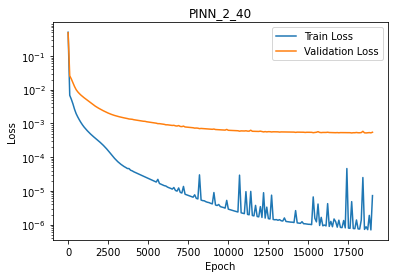

In [16]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

### 4.6. Perform an error analysis

In [17]:
np.random.seed(42)
reduction_method.initialize_testing_set(100, DEIM=60)
test_mu = torch.tensor(reduction_method.testing_set)

#### 4.6.1 Greedy PDNN-PINN Error Analysis

In [18]:
pdnn_net.load_best_weights()
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn
)

0:  |F(x)| = 3.66822; step 0.315858
1:  |F(x)| = 1.69948; step 0.469045
2:  |F(x)| = 0.0774299; step 1
3:  |F(x)| = 0.00151968; step 1
4:  |F(x)| = 4.64583e-06; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 3.55931; step 0.34364
1:  |F(x)| = 1.88873; step 0.441284
2:  |F(x)| = 0.179282; step 1
3:  |F(x)| = 0.0057149; step 1
4:  |F(x)| = 4.98545e-06; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 0.131237; step 1
1:  |F(x)| = 0.000405068; step 1
2:  |F(x)| = 5.87374e-08; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 3.69817; step 0.327128
1:  |F(x)| = 2.32763; step 0.346343
2:  |F(x)| = 0.902364; step 1
3:  |F(x)| = 0.148806; step 1
4:  |F(x)| = 0.00610767; step 1
5:  |F(x)| = 8.58691e-06; step 1
6:  |F(x)| = 3.04928e-08; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 3.71431; step 0.315456
1:  |F(x)| = 2.83838; step 0.227453
2:  |F(x)| = 0.967041; step 1
3:  |F(x)| = 0.133222; step 1
4:  |F(x)| = 0.00352944; step 1
5:  |F(x)| = 4.98

2:  |F(x)| = 0.256256; step 1
3:  |F(x)| = 0.011138; step 1
4:  |F(x)| = 1.34293e-05; step 1
5:  |F(x)| = 1.19844e-07; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 0.0902532; step 1
1:  |F(x)| = 8.74358e-05; step 1
2:  |F(x)| = 8.32529e-08; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 0.97568; step 1
1:  |F(x)| = 0.10877; step 1
2:  |F(x)| = 0.00173501; step 1
3:  |F(x)| = 6.20357e-07; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 3.65753; step 0.326138
1:  |F(x)| = 2.31911; step 0.347651
2:  |F(x)| = 0.393247; step 1
3:  |F(x)| = 0.0259124; step 1
4:  |F(x)| = 0.00010823; step 1
5:  |F(x)| = 4.44742e-07; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 2.6734; step 0.489348
1:  |F(x)| = 0.373273; step 1
2:  |F(x)| = 0.0197048; step 1
3:  |F(x)| = 6.08761e-05; step 1
4:  |F(x)| = 8.74623e-08; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 3.41663; step 0.375237
1:  |F(x)| = 1.34583; step 0.542712
2:  |F(x)| = 0.0524395

0:  |F(x)| = 0.333706; step 1
1:  |F(x)| = 0.00560108; step 1
2:  |F(x)| = 1.59195e-06; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 1.48987; step 1
1:  |F(x)| = 0.34935; step 1
2:  |F(x)| = 0.0312479; step 1
3:  |F(x)| = 0.000278772; step 1
4:  |F(x)| = 1.38611e-07; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 0.0444948; step 1
1:  |F(x)| = 2.35854e-05; step 1
2:  |F(x)| = 1.77482e-07; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 0.691379; step 1
1:  |F(x)| = 0.0362448; step 1
2:  |F(x)| = 0.000123998; step 1
3:  |F(x)| = 8.69502e-08; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 0.549389; step 1
1:  |F(x)| = 0.0162663; step 1
2:  |F(x)| = 1.79055e-05; step 1
3:  |F(x)| = 4.15765e-08; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 3.4214; step 0.375875
1:  |F(x)| = 0.817473; step 1
2:  |F(x)| = 0.0841254; step 1
3:  |F(x)| = 0.00113107; step 1
4:  |F(x)| = 6.58239e-07; step 1
scipy solver converged in 6 iterations

#### 4.6.2 PRNN Error Analysis

In [19]:
prnn_net.load_best_weights()
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn
)

#################################### N = 8 #####################################
ERROR	NN-HF			NN-RO			RO-HF
min	9.702193503455737e-05	7.284451770780491e-05	1.4561048699820823e-05
mean	0.0009193204918583112	0.0009092212750743415	7.140450626433022e-05
max	0.031050901035975888	0.03105380638658379	0.0002885727936929961


#### 4.6.3 PINN Error Analysis

In [20]:
pinn_net.load_best_weights()
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn
)

#################################### N = 8 #####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.00010501880424826718	8.481925868092805e-05	1.4561048699820823e-05
mean	0.001083848831111648	0.001074877990586024	7.140450626433022e-05
max	0.032592391058954596	0.03259462451885052	0.0002885727936929961
